In [2]:
!pip install tensorflow keras opencv-python

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
import cv2
import numpy as np
import os
import time

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dir = '/content/drive/MyDrive/machine-learning-project/data/'

In [6]:
def load_tfrecord_dataset(file_path):
    # Define a function to parse the TFRecord file
    feature_description = {
        'image': tf.io.FixedLenFeature([224 * 224 * 1], tf.float32),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }

    def _parse_function(example_proto):
        # Parse the input tf.train.Example proto using the feature description
        parsed_features = tf.io.parse_single_example(example_proto, feature_description)
        image = tf.reshape(parsed_features['image'], [224, 224, 1])
        label = parsed_features['label']
        return image, label

    # Load and parse the dataset
    raw_dataset = tf.data.TFRecordDataset(file_path)
    parsed_dataset = raw_dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    return parsed_dataset

# Load the datasets from TFRecord files
ds_train = load_tfrecord_dataset(f'{dir}ds_train.tfrecord')
ds_val = load_tfrecord_dataset(f'{dir}ds_val.tfrecord')
ds_test = load_tfrecord_dataset(f'{dir}ds_test.tfrecord')

In [7]:
for img,label in ds_train.take(1):
    print(img.shape)
    print(label)

(224, 224, 1)
tf.Tensor(2, shape=(), dtype=int64)


In [8]:
for img,label in ds_val.take(1):
    print(img.shape)
    print(label)

(224, 224, 1)
tf.Tensor(0, shape=(), dtype=int64)


In [9]:
for img,label in ds_test.take(1):
    print(img.shape)
    print(label)

(224, 224, 1)
tf.Tensor(0, shape=(), dtype=int64)


In [10]:


# Preprocess the datasets for EfficientNet
def preprocess_dataset_for_efficientnet(dataset):
    # Apply preprocessing using a lambda function to convert grayscale to RGB and preprocess
    def refactor(image, label):
        # Convert grayscale images to RGB
        image = tf.image.grayscale_to_rgb(image)
        # Apply EfficientNet preprocessing
        image = tf.keras.applications.efficientnet.preprocess_input(image)
        return image, label

    # Apply the refactor function to the dataset
    dataset = dataset.map(refactor, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

# Apply the modified preprocessing to datasets
ds_train = preprocess_dataset_for_efficientnet(ds_train)
ds_val = preprocess_dataset_for_efficientnet(ds_val)
ds_test = preprocess_dataset_for_efficientnet(ds_test)

In [11]:
# Batch the datasets for training and evaluation
batch_size = 16
ds_train = ds_train.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
ds_val = ds_val.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
# Load the EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Build the model
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [17]:
# Measure training time
start_time = time.time()

# Train the model
history = model.fit(ds_train, epochs=10, validation_data=ds_val)

# Measure and print runtime
print(f"Training time: {time.time() - start_time:.2f} seconds")

Epoch 1/10
     85/Unknown 130s 1s/step - accuracy: 0.1051 - loss: -0.4077

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


85/85 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.1049 - loss: -0.4114 - val_accuracy: 0.1000 - val_loss: -2.3180
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.0876 - loss: -2.0933 - val_accuracy: 0.1000 - val_loss: -5.2267
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.0888 - loss: -5.2955 - val_accuracy: 0.1118 - val_loss: -10.2186
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.0967 - loss: -8.2394 - val_accuracy: 0.1118 - val_loss: -17.3173
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.0924 - loss: -15.6222 - val_accuracy: 0.1118 - val_loss: -27.1629
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.0900 - loss: -20.3046 - val_accuracy: 0.1118 - val_loss: -38.9912
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.0951 - loss: -29.9188 - val_accuracy: 0.1118 - val_loss: -52.5084
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.0904 - loss: -39.0051 - val_accurac

In [18]:
# Evaluate the model
eval_results = model.evaluate(ds_test)
print(f"Test Loss: {eval_results[0]}, Test Accuracy: {eval_results[1]}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.0651 - loss: -76.6799
Test Loss: -85.91635131835938, Test Accuracy: 0.06470588594675064


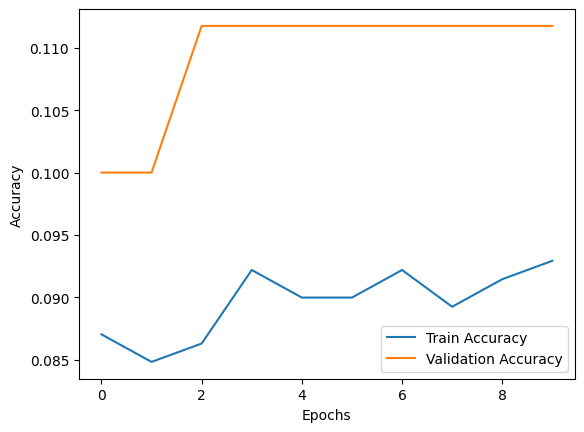

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()